Write your findings & recommendations as if you are presenting to someone outside of the
data science team (i.e. an engineer or product manager) who will be making decisions
about the initial experience users receive when they first create their accounts. Their work
will focus on improving this experience to increase adoption, so they'd like to know how
successful Asana currently is at getting different types of users to adopt.

### Data Ingestion

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns

In [34]:
users = pd.read_csv("takehome_users-intern.csv")
user_engagement = pd.read_csv("takehome_user_engagement-intern.csv")

# users = pd.read_csv("https://s3.amazonaws.com/asana-data-interview/takehome_users-intern.csv")
# user_engagement = pd.read_csv("https://s3.amazonaws.com/asana-data-interview/takehome_user_engagement-intern.csv")

### Data Cleaning

In [35]:
users = users.rename(columns={'object_id': 'user_id'}) #rename object_id to user_id for future join
users['email'] = users['email'].str.lower() #converting all email to lowercase

users['creation_time'] = pd.to_datetime(users['creation_time'], unit = 'ns')
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')

#changing type to category
users['creation_source'] = users['creation_source'].astype('category') 
users['org_id'] = users['org_id'].astype('category')

#changing type to boolean
users['opted_in_to_mailing_list'] = users['opted_in_to_mailing_list'].astype(bool)
users['enabled_for_marketing_drip'] = users['enabled_for_marketing_drip'].astype(bool)

#filling NaNs as 0, since the minimum value in the invited_by_user_id column is 3.0
users['invited_by_user_id'].fillna(0, inplace=True)
users['invited_by_user_id'] = users['invited_by_user_id'].astype(int)

In [36]:
users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,email_domain
0,1,2014-04-22 03:53:00,Clausen August,augustcclausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,True,False,11,10803,yahoo.com
1,2,2013-11-15 03:45:00,Poole Matthew,matthewpoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,False,False,1,316,gustr.com
2,3,2013-03-19 23:14:00,Bottrill Mitchell,mitchellbottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,False,False,94,1525,gustr.com
3,4,2013-05-21 08:09:00,Clausen Nicklas,nicklassclausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,False,False,1,5151,yahoo.com
4,5,2013-01-17 10:14:00,Raw Grace,graceraw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,False,False,193,5240,yahoo.com


### Data Exploration

By plotting the `org_id count`, I found that the data is left skewed. I divided the data into 5 groups by percentile and create a new column `org_group`.

I then merged `org_id_value_counts` back to `users`.

In [219]:
# Step 1: Determine the threshold
threshold = 1000

# Step 2: Create a custom function to apply
def group_low_volume_categories(email_domain):
    counts = users['email_domain'].value_counts()
    if counts[email_domain] < threshold:
        return 'Other'
    return email_domain

# Step 3: Apply the custom function to the 'email domain' column
users['email_domain'] = users['email_domain'].apply(group_low_volume_categories)


<Axes: xlabel='email_domain'>

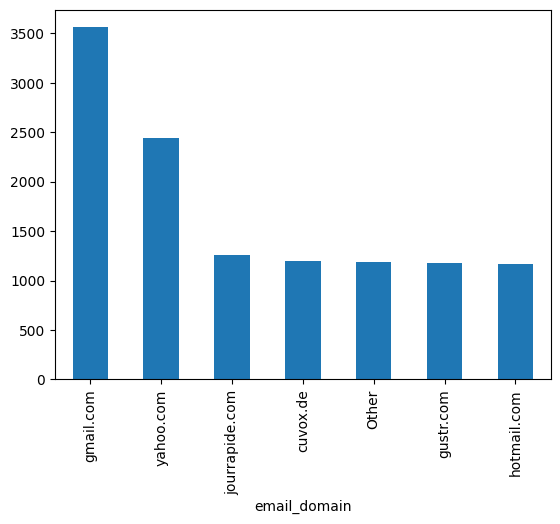

In [220]:
users['email_domain'].value_counts().head(10).plot(kind='bar')

In [221]:
users['email_domain'] = users['email_domain'].astype('category')

Timestamp Columns

Are there gaps in the time series (e.g. missing a whole day or multiple days, days with shockingly low volume)?
Are there missing values? Handling missing data could be a whole post on its own, but this article is a good resource for how to think about it.

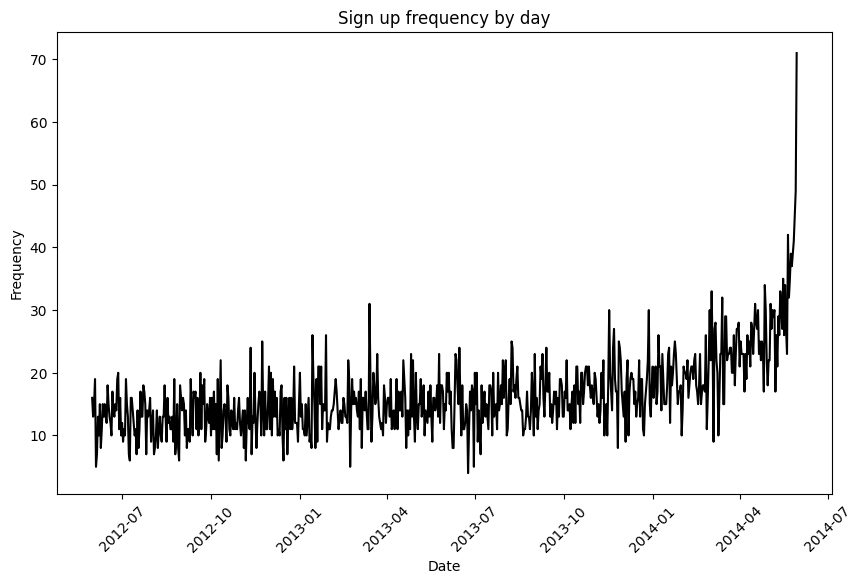

In [223]:
#plot creation_time

# Group by date-time and count the frequency
frequency = users.groupby(users['creation_time'].dt.date)['creation_time'].size()

# Create a bar plot
plt.figure(figsize=(10, 6))
frequency.plot(color='black', linestyle='-')
plt.title('Sign up frequency by day')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [224]:
max(users['creation_time'].dt.date.value_counts())

71

In [228]:
#No significant gap in the time series - maximum gap is 19 hours and 18 minutes

from datetime import datetime, timedelta

creation_time_analysis = pd.DataFrame(users)

# Set 'timestamp' as the index
creation_time_analysis.set_index('creation_time', inplace=True)

# Sort the DataFrame by the index (timestamp)
creation_time_analysis.sort_index(inplace=True)

# Calculate time gaps between consecutive timestamps
time_diff = creation_time_analysis.index.to_series().diff()

# Define a threshold for gap detection (e.g., 15 minutes)
gap_threshold = timedelta(minutes=720)

# Find gaps exceeding the threshold
gaps = time_diff[time_diff > gap_threshold]

if not gaps.empty:
    print("Gaps in the time series:")
    print(gaps)
else:
    print("No significant gaps in the time series.")

Gaps in the time series:
creation_time
2012-07-26 22:08:00   0 days 15:36:00
2012-08-05 05:48:00   0 days 14:42:00
2012-08-29 17:02:00   0 days 19:18:00
2012-12-31 04:25:00   0 days 15:33:00
2013-07-07 21:17:00   0 days 14:48:00
Name: creation_time, dtype: timedelta64[ns]


### 1) Calculating Adoption Rate

In [28]:
user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [230]:
#remove 'visited' column

In [29]:
#use only the user_engagement table to calculate the adoption rate
#convert timestamp into a list 

#create a new df
list_of_users = user_engagement.user_id.unique().tolist()
hMap = {i: [] for i in list_of_users}
for index,row in user_engagement.iterrows():
    hMap[row['user_id']].append(row['time_stamp'])

#sort each login_date in ascending order
#  
user_engagement_revised = pd.DataFrame(list(hMap.items()), columns=['user_id', 'login_dates'])
user_engagement_revised.head()

,user_id,login_dates
0,1,[2014-04-22 03:53:30]
1,2,"[2013-11-15 03:45:04, 2013-11-29 03:45:04, 201..."
2,3,[2013-03-19 23:14:52]
3,4,[2013-05-22 08:09:28]
4,5,[2013-01-22 10:14:20]


In [30]:
# Convert each string in the list to a datetime object using apply and a lambda function
user_engagement_revised['login_dates'] = user_engagement_revised['login_dates'].apply(lambda x: [pd.to_datetime(date_str) for date_str in x])

We define an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day period. Because we believe that adopted users are more likely to be successful at using Asana in the long term than those that are not adopted, we want to know what things are likely indicators of future adoption. 

In [233]:
#change this to sliding window

from datetime import timedelta

def has_adopted(row):
    sorted_dates = sorted(row['login_dates'])
    
    # Initialize variables to track consecutive logins and the start date of the current window
    consecutive_logins = 0
    current_start_date = None
    
    # Define the 7-day time window
    seven_days = timedelta(days=7)
    
    list_of_dates = []
    # 1 6 8 9
    # Iterate through the sorted dates
    for date in sorted_dates:
        if current_start_date is None:
            current_start_date = date
            consecutive_logins = 1
            list_of_dates.append(current_start_date)
        elif date - current_start_date <= seven_days:
            consecutive_logins += 1
            list_of_dates.append(date)
        else:
            current_start_date = date
            list_of_dates = [current_start_date]
            consecutive_logins = 1
        
        if consecutive_logins >= 3:
            print(list_of_dates)
            return True
    
    return False

In [235]:
if 'login_dates' in user_engagement_revised.columns:
    # If it exists, apply the 'adopted_user' function
    user_engagement_revised['has_adopted'] = user_engagement_revised.apply(has_adopted, axis=1)
else:
    print("The 'login_date' column does not exist in the DataFrame.")

[Timestamp('2014-02-03 03:45:04'), Timestamp('2014-02-08 03:45:04'), Timestamp('2014-02-09 03:45:04')]
[Timestamp('2013-01-30 22:08:03'), Timestamp('2013-02-04 22:08:03'), Timestamp('2013-02-06 22:08:03')]
[Timestamp('2014-03-11 11:46:38'), Timestamp('2014-03-12 11:46:38'), Timestamp('2014-03-13 11:46:38')]
[Timestamp('2014-05-12 06:29:09'), Timestamp('2014-05-14 06:29:09'), Timestamp('2014-05-19 06:29:09')]
[Timestamp('2012-12-24 19:05:07'), Timestamp('2012-12-25 19:05:07'), Timestamp('2012-12-26 19:05:07')]
[Timestamp('2013-03-08 07:13:17'), Timestamp('2013-03-09 07:13:17'), Timestamp('2013-03-11 07:13:17')]
[Timestamp('2012-08-15 11:02:08'), Timestamp('2012-08-18 11:02:08'), Timestamp('2012-08-22 11:02:08')]
[Timestamp('2013-02-13 23:47:15'), Timestamp('2013-02-15 23:47:15'), Timestamp('2013-02-17 23:47:15')]
[Timestamp('2014-03-29 22:56:03'), Timestamp('2014-04-02 22:56:03'), Timestamp('2014-04-05 22:56:03')]
[Timestamp('2013-01-18 16:30:52'), Timestamp('2013-01-24 16:30:52'), Time

3. Segment, Segment, Segment
Segmentation is key to unlocking insights in analytics. The goal of segmentation is to split your data along some dimension so that you can assess performance between different groups. In a product analytics setting, some common segmentations include free vs paid users, device type (desktop web vs mobile web vs native app), traffic source (people coming from search engines, paid marketing, people directly typing in your company’s URL into their browser, etc.), and day of the week.

I tend to try many possible segmentations to see what provides interesting results. If you’re not sure where to start, categorical columns are good candidates for segmentation. Sometimes, you’ll want to filter out low-volume categories or group them into an ‘Other’ category to remove clutter from your visualization.

You can also create boolean columns from numerical ones (e.g. whether a user spent more than $50, if user had activity on the weekend) or discretize columns by creating different buckets (e.g. timestamp to morning/afternoon/ night, order values into buckets of $10–20, $20–30, $30+).

### 2) Methodology

##### 2a) Writeup associated with methodology